In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sigma = 1.  # Standard deviation.
mu = 10.  # Mean.
tau = .05  # Time constant.

In [3]:
dt = .001  # Time step.
T = 1.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

In [4]:
sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)

In [5]:
x = np.zeros(n)

Euler-Maruyama induces and interative map

In [7]:
for i in range(n - 1):
    x[i + 1] = x[i] + dt * (-(x[i] - mu) / tau) + sigma_bis * sqrtdt * np.random.randn()

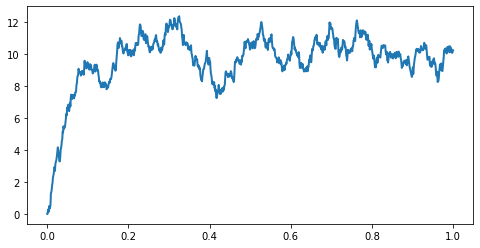

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, x, lw=2)

Multiple trials 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


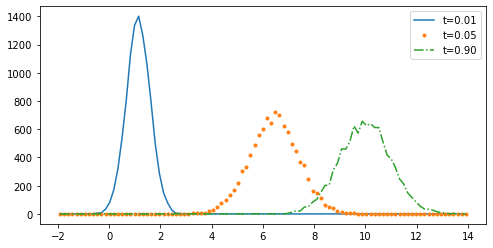

In [9]:
ntrials = 10000
X = np.zeros(ntrials)
# We create bins for the histograms.
bins = np.linspace(-2., 14., 100)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in range(n):
    # We update the process independently for
    # all trials
    X += dt * (-(X - mu) / tau) + sigma_bis * sqrtdt * np.random.randn(ntrials)
    # We display the histogram for a few points in
    # time
    if i in (5, 50, 900):
        hist, _ = np.histogram(X, bins=bins)
        ax.plot((bins[1:] + bins[:-1]) / 2, hist,
                {5: '-', 50: '.', 900: '-.', }[i],
                label=f"t={i * dt:.2f}")
    ax.legend()
    

# Noisy saddle

In [1]:
import pylds
import numpy as np
from pylds.base import generate_points, perturb_field
from pylds.tools import draw_all_lds

In [2]:
from pylds.base import generate_points, lagrangian_descriptor

In [3]:
def Saddle1D(t, u, PARAMETERS = [1, 1]):
    """
    Returns 1D Hamilton-Saddle vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [lamda]
    Functional form: v = (lamda*y, - lamda*x), with u = (x, y)

    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space.

    u : array_like, shape(n,)
        points in phase space to determine vector field at time t.

    PARAMETERS : list of floats
        vector field parameters

    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x, y = u.T
    # Hamiltonian Model Parameter
    a1, a2 = PARAMETERS
    v = np.column_stack([ a1*x, -a2*y])
    return v

In [4]:
def stochastic_forcing(t, u, PARAMETERS = [-20, 20]):
    """
    Returns vector field for a perturbation at time t, for an array of points in phase space.
    Number of model parameters: 3. perturbation_params = [perturbation_type, amplitude, frequency]
    Functional form: v = (, ), with u = (x, y)

    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space.

    u : array_like, shape(n,)
        points in phase space to determine vector field at time t.

    perturbation_params : list of floats, [perturbation_type, amplitude, frequency]
        vector field parameters

    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x, y = u.T
    perturbation = np.zeros(u.shape)

    # Perturbation parameters
    sigma = PARAMETERS
    sigma = np.array(sigma)
    dW = np.random.randn(*u.shape)
    
    perturbation = sigma*dW

    return perturbation

In [5]:
vector_field_original = Saddle1D
vector_field = perturb_field(vector_field_original, stochastic_forcing)

In [6]:
vector_field_new = lambda u: vector_field(0, u)

In [7]:
u = np.array([[1,2],[1,2],[1,2]])

In [8]:
vector_field_new(u)

array([[-14.10407966,  -4.28628853],
       [  8.53129652,  -9.226449  ],
       [ -7.58135157,  -1.12207707]])

In [9]:
1/0.05

20.0

Grid of initial conditions

In [10]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.1

# Mesh parameters
x_min,x_max = [-1, 1]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [11]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

In [12]:
N_mesh_axes = len(grid_parameters)+1
u0, mask = generate_points(grid_parameters)
u0 = u0.reshape(-1,N_mesh_axes)
u0 = u0[:,:-1] # exclude LD-axis

In [13]:
from pylds.tools import draw_all_lds

In [14]:
def compute_lagrangian_descriptor(grid_parameters, discrete_map, tau, p_value=0.5, box_boundaries=False, periodic_boundaries=False):
    """
    Returns the values of the LD function from trajectories from iterated initial conditions in plane by a map.
    
    Parameters
    ----------
    grid_parameters : list of 3-tuples of floats
        input parameters of limits and size of mesh per axis.
    
    discrete_map: function
        map of discrete 2D dynamical system.
        
    tau : float
        Upper limit of integration.
        
    p_value : float, optional
        Exponent in Lagrangian descriptor definition.
        0 is the acton-based LD,
        0 < p_value < 1 is the Lp quasinorm,
        1 <= p_value < 2 is the Lp norm LD,
        2 is the arclength LD.
        The default is 0.5.
    
    box_boundaries : list of 2-tuples, optional
        Box boundaries for escape condition of variable time integration.
        Boundaries are infinite by default.
        
    perodic_boundaries: list of floats
        Lenght values of periodic box axes (2D default).
        PBC are False by default.
    Returns
    -------
    LD : ndarray, shape (Nx, Ny)
        Array of computed Lagrangian descriptor values for all initial conditions.
    """
    N_mesh_axes = len(grid_parameters)+1
    y0, mask = generate_points(grid_parameters)
    y0 = y0.reshape(-1,N_mesh_axes)
    y0 = y0[:,:-1] # exclude LD-axis
        
    f = discrete_map

    LD_values = np.zeros(len(y0))
    for i in range(N_iterations):
        y = f(y0)
        # Escape box condition
#         if box_boundaries:
#             y_inbox = check_if_points_escape_box(y, box_boundaries)
#             y[y_inbox == False] = y0[y_inbox == False]
        
        # Periodic Boundary conditions
        dy = y-y0
#         if periodic_boundaries:
#             dy = pbc_correction_distances(dy, periodic_boundaries)
#             #y0 = y0 - np.floor(y0 + 1/2) #James Miss' mod function
#             y0 = pbc_correction_coords(y0, periodic_boundaries)
#             y  = pbc_correction_coords(y , periodic_boundaries)
                
        LD_values = LD_values + lagrangian_descriptor(y0, dy, p_value)
        y0 = y

    N_points_slice_axes = [x[-1] for x in grid_parameters] #take number of points
    LD = LD_values.reshape(*N_points_slice_axes) #reshape to 2-D array  

    if p_value<=1:
        return LD
    else:
        return LD**(1/p_value)

In [15]:
discrete_map = vector_field_new

In [16]:
tau = 15
dt = 0.05

In [18]:
N_trials = 100

In [20]:
LD_forward_mean = []

for n in range(N_trials):
    LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map, N_iterations, p_value=0.5)
    LD_forward_mean.append(LD_forward)

In [21]:
LD_forward_mean = np.array(LD_forward_mean).mean(axis=1)

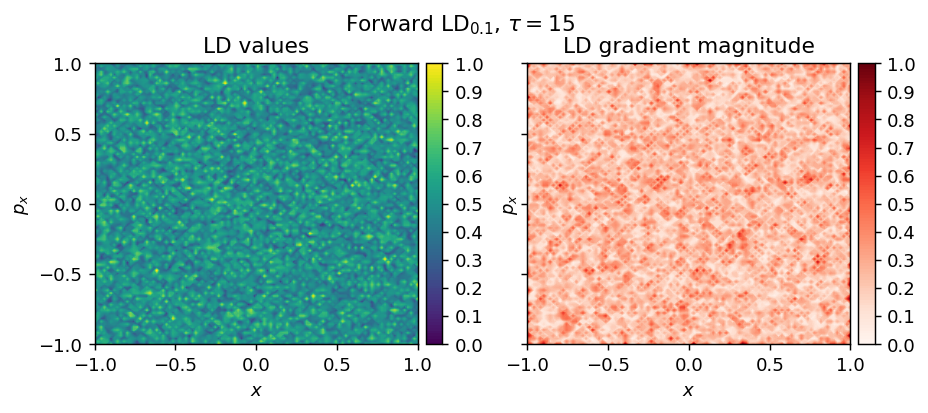

In [22]:
p = draw_all_lds(LD_forward_mean, [], grid_parameters, tau, p_value)